In [ ]:
import numpy as np
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D
from keras import optimizers
import matplotlib.pyplot as plt
import math 

In [21]:
#Variable Definition
img_width, img_height = 256, 256
top_model_weights_path = 'bottleneck_fc_model.h5'
epochs = 30 
batch_size = 30

In [22]:
#VGG16 Model
from keras.applications import vgg16

vgg16 = vgg16.VGG16(include_top=False, weights='imagenet')

In [23]:
#Data Augmentation and Bottleneck features generation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1. / 255
)

In [24]:
# Training Bottleneck
generator  = datagen.flow_from_directory('ProductClassifier/Data/train/',
                                         shuffle=False,
                                         class_mode=None,
                                         batch_size=batch_size,
                                         target_size=(img_width, img_height))

nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 

bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train) 

np.save('bottleneck_features_train.npy', bottleneck_features_train)

Found 2119 images belonging to 12 classes.


In [25]:
# Validation Bottleneck
generator  = datagen.flow_from_directory('ProductClassifier/Data/test/',
                                         shuffle=False,
                                         class_mode=None,
                                         batch_size=batch_size,
                                         target_size=(img_width, img_height))

nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices)

predict_size_validation = int(math.ceil(nb_train_samples / batch_size)) 

bottleneck_features_validation = vgg16.predict_generator(generator, predict_size_validation) 

np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

Found 565 images belonging to 12 classes.


In [26]:
# Training Data set
generator_top = datagen.flow_from_directory( 
   'ProductClassifier/Data/train/', 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
train_data = np.load('bottleneck_features_train.npy') 
train_labels = generator_top.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 2119 images belonging to 12 classes.


In [27]:
# Validation Data Set
generator_top = datagen.flow_from_directory( 
   'ProductClassifier/Data/test/', 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
validation_data = np.load('bottleneck_features_validation.npy') 
validation_labels = generator_top.classes 
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 565 images belonging to 12 classes.


In [28]:
model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(100)) 
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(Dropout(0.5)) 
model.add(Dense(50))
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
   optimizer=optimizers.RMSprop(lr=1e-4),
   metrics=['acc'])
history = model.fit(train_data, train_labels, 
   epochs=epochs,
   batch_size=batch_size, 
   validation_data=(validation_data, validation_labels))
model.save_weights(top_model_weights_path)
(eval_loss, eval_accuracy) = model.evaluate( 
    validation_data, validation_labels, batch_size=batch_size,     verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2119 samples, validate on 565 samples
Epoch 1/30
2119/2119 [==============================] - 3s 2ms/step - loss: 1.5371 - acc: 0.5163 - val_loss: 0.9056 - val_acc: 0.7770
Epoch 2/30
2119/2119 [==============================] - 2s 1ms/step - loss: 0.8622 - acc: 0.7329 - val_loss: 0.7989 - val_acc: 0.7628
Epoch 3/30
2119/2119 [==============================] - 2s 999us/step - loss: 0.6123 - acc: 0.8193 - val_loss: 0.6083 - val_acc: 0.8230
Epoch 4/30
2119/2119 [==============================] - 2s 1ms/step - loss: 0.4906 - acc: 0.8551 - val_loss: 0.5861 - val_acc: 0.8212
Epoch 5/30
2119/2119 [==============================] - 2s 1ms/step - loss: 0.4031 - acc: 0.8782 - val_loss: 0.5482 - val_acc: 0.8212
Epoch 6/30
2119/2119 [==============================] - 2s 1ms/step - loss: 0.3291 - acc: 0.9018 - val_loss: 0.5002 - val_acc: 0.8531
Epoch 7/30
2119/2119 [=============================

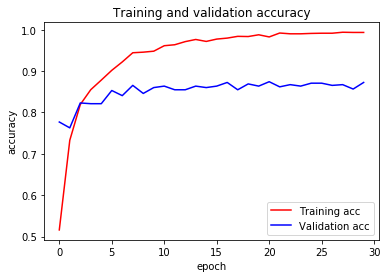

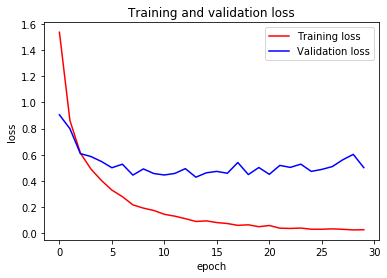

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [30]:
from sklearn import metrics
preds = np.round(model.predict(validation_data), 0)
predicted_classes = np.argmax(preds, axis=1)
true_classes = generator_top.classes
class_labels = list(generator_top.class_indices.keys())


In [31]:
report = metrics.classification_report(validation_labels, preds, target_names=class_labels)
print(report) 

                  precision    recall  f1-score   support

            bags       0.90      0.89      0.90       141
         banners       0.91      0.82      0.86        49
   business-card       0.82      0.92      0.87       103
     door-hanger       0.87      0.91      0.89        53
            hats       0.97      0.97      0.97        35
            mugs       0.97      0.95      0.96        40
    office-signs       1.00      0.44      0.61        16
            pens       1.00      1.00      1.00        23
     phone-cases       0.95      0.73      0.82        48
          stamps       0.00      0.00      0.00         0
    table-covers       0.94      0.81      0.87        42
usb-flash-drives       0.73      0.53      0.62        15

       micro avg       0.90      0.86      0.88       565
       macro avg       0.84      0.75      0.78       565
    weighted avg       0.90      0.86      0.88       565
     samples avg       0.86      0.86      0.86       565



C:\Users\Xavi\Anaconda3\envs\TFM\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Xavi\Anaconda3\envs\TFM\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [32]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import itertools

categorical_test_labels = pd.DataFrame(validation_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

cm = confusion_matrix(categorical_test_labels, categorical_preds)

def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="black" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

C:\Users\Xavi\Anaconda3\envs\TFM\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


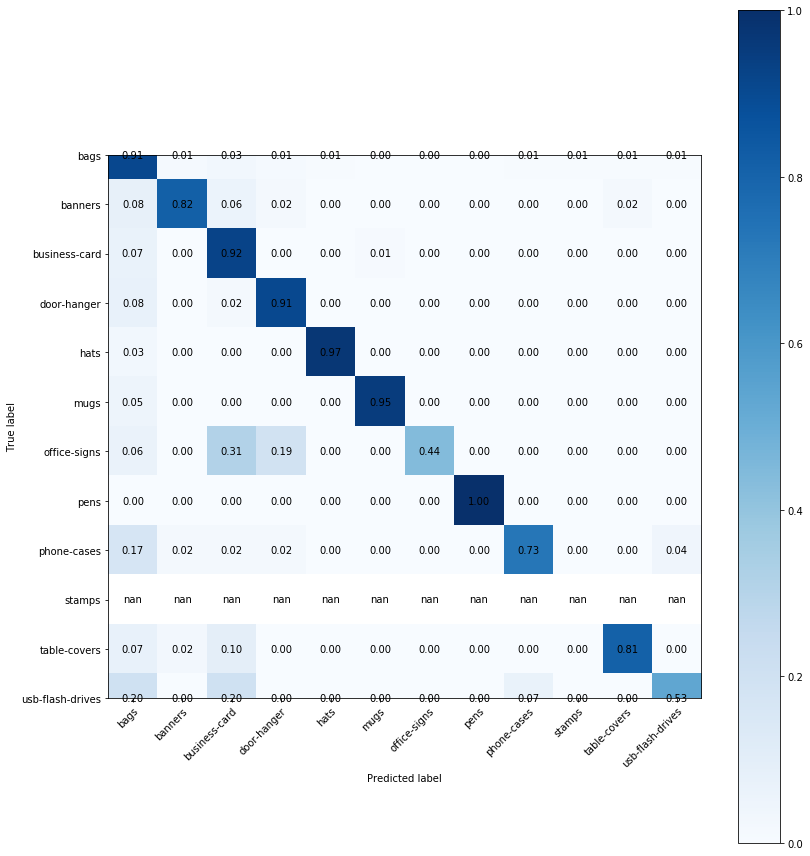

In [33]:
plot_confusion_matrix(cm, class_labels, normalize=True)

In [35]:
#Save the model

vgg16_yaml = vgg16.to_yaml()
with open("ProductClassifier/Model/vgg16_model.yaml", "w") as yaml_file:
    yaml_file.write(vgg16_yaml)
vgg16.save_weights("Model/vgg16.h5")

model_yaml = model.to_yaml()
with open("ProductClassifier/Model/classification_model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
model.save_weights("ProductClassifier/Model/classification_model.h5")